In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cd import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

ModuleNotFoundError: No module named 'pyfunctions.cd'

## load in model and data

In [3]:
torch.autograd.set_grad_enabled(False)

In [4]:
args = {
    'model_type': 'bert', # bert, medical_bert, pubmed_bert, biobert, clinical_biobert
    'task': 'path',
    'field': 'PrimaryGleason'
}

device = 'cuda:0'

In [5]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'medical_bert':
    bert_path = f"{base_dir}/models/pretrained/bert_pretrain_output_all_notes_150000/"
    tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'pubmed_bert_full':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [6]:
# Read in data
#field = 'PrimaryGleason' # out of PrimaryGleason, SecondaryGleason', 'MarginStatusNone', 'SeminalVesicleNone'
path = f"../data/prostate.json"
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
print(len(train_documents), len(val_documents),len(test_documents))

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors


2066 517 324


In [7]:
# Create datasets
train_labels = [patient['labels'][args['field']] for patient in data['train']]
val_labels = [patient['labels'][args['field']] for patient in data['val']]
test_labels = [patient['labels'][args['field']] for patient in data['test']]

train_documents, train_labels = exclude_labels(train_documents, train_labels)
val_documents, val_labels = exclude_labels(val_documents, val_labels)
test_documents, test_labels = exclude_labels(test_documents, test_labels)

le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)

# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [8]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

In [9]:
#load finetuned model
model_path = f"{base_dir}/models/{args['task']}/{args['model_type']}_{args['field']}"
checkpoint_file = f"{model_path}/save_output"
config_file = f"{model_path}/save_output/config.json"

model = BertForSequenceClassification.from_pretrained(checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)

model = model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
def reshape_separate_attention_heads(context_layer, sa_module):
    new_shape = context_layer.size()[:-1] + (sa_module.num_attention_heads, sa_module.attention_head_size)
    context_layer = context_layer.view(new_shape)
    return context_layer

def reshape_concatenate_attention_heads(context_layer, sa_module):
    new_shape = context_layer.size()[:-2] + (sa_module.all_head_size,)
    context_layer = context_layer.view(*new_shape)
    return context_layer

def prop_self_attention_patched(rel, irrel, attention_mask, 
                                head_mask, patched_entries, layer_patched_values,
                                sa_module, att_probs = None):
    
    if att_probs is not None:
        att_probs = att_probs
    else:
        att_probs = get_attention_probs(rel + irrel, attention_mask, head_mask, sa_module)
    
    rel_value, irrel_value = prop_linear(rel, irrel, sa_module.value)
    
    rel_context = mul_att(att_probs, rel_value, sa_module)
    irrel_context = mul_att(att_probs, irrel_value, sa_module)
        
    return rel_context, irrel_context
    
def patch_context_eval(rel, irrel, patched_entries, layer_patched_values, sa_module):
    rel = reshape_separate_attention_heads(rel, sa_module)
    irrel = reshape_separate_attention_heads(irrel, sa_module)

    for i, entry in enumerate(patched_entries):
        pos = entry[1]
        att_head = entry[2]
        
        rel[:, pos, att_head, :] = rel[:, pos, att_head, :] + irrel[:, pos, att_head, :]
        irrel[:, pos, att_head, :] = 0
        
    rel = reshape_concatenate_attention_heads(rel, sa_module)
    irrel = reshape_concatenate_attention_heads(irrel, sa_module)
    return rel, irrel

def prop_attention_patched_baseline(rel, irrel, attention_mask, 
                           head_mask, patched_entries, layer_patched_values, a_module, 
                           att_probs = None):

    
    rel_context, irrel_context = prop_self_attention_patched(rel, irrel, 
                                                             attention_mask, 
                                                             head_mask, 
                                                             patched_entries,
                                                             layer_patched_values,
                                                             a_module.self, att_probs)

    output_module = a_module.output
    
    rel_dense, irrel_dense = prop_linear(rel_context, irrel_context, output_module.dense)
    rel_tot = rel_dense + rel
    irrel_tot = irrel_dense + irrel
        
    rel_tot, irrel_tot = patch_context_eval(rel_tot, irrel_tot, patched_entries, layer_patched_values, a_module.self)
    
    rel_out, irrel_out = prop_layer_norm(rel_tot, irrel_tot, output_module.LayerNorm)
    
    return rel_out, irrel_out

def prop_layer_patched(rel, irrel, attention_mask, head_mask, patched_entries, layer_patched_values, layer_module, att_probs = None):
    
    rel_a, irrel_a = prop_attention_patched_baseline(rel, irrel, attention_mask, head_mask,
                                                     patched_entries, layer_patched_values,
                                                     layer_module.attention, att_probs)
    
    i_module = layer_module.intermediate
    rel_id, irrel_id = prop_linear(rel_a, irrel_a, i_module.dense)
    rel_iact, irrel_iact = prop_act(rel_id, irrel_id, i_module.intermediate_act_fn)
    
    o_module = layer_module.output
    rel_od, irrel_od = prop_linear(rel_iact, irrel_iact, o_module.dense)
    
    rel_tot = rel_od + rel_a
    irrel_tot = irrel_od + irrel_a
    
    rel_out, irrel_out = prop_layer_norm(rel_tot, irrel_tot, o_module.LayerNorm)
    
    # import pdb; pdb.set_trace()
    
    return rel_out, irrel_out

In [11]:
def ablate_target_nodes(encoding, model, patched_entries, patched_values=None, att_list = None):
    
    embedding_output = get_embeddings_bert(encoding, model.bert)
    input_shape = encoding['input_ids'].size()
    extended_attention_mask = get_extended_attention_mask(attention_mask = encoding['attention_mask'], 
                                                          input_shape = input_shape, 
                                                          bert_model = model.bert,
                                                          device = device)
    
    head_mask = [None] * model.bert.config.num_hidden_layers
    encoder_module = model.bert.encoder
    
    sh = list(embedding_output.shape)
    
    rel = torch.zeros(sh, dtype = embedding_output.dtype, device = device)
    irrel = torch.zeros(sh, dtype = embedding_output.dtype, device = device)
    
    irrel[:] = embedding_output[:]

    for i, layer_module in enumerate(encoder_module.layer):
        layer_patched_entries = [p_entry for p_entry in patched_entries if p_entry[0] == i]
        layer_head_mask = head_mask[i]
        att_probs = None
        
        if patched_values is not None:
            layer_patched_values = patched_values[i]
        else:
            layer_patched_values = None
        
        rel_n, irrel_n = prop_layer_patched(rel, irrel, extended_attention_mask,
                                            layer_head_mask, layer_patched_entries,
                                            layer_patched_values,
                                            layer_module, att_probs)
        normalize_rel_irrel(rel_n, irrel_n)
        rel, irrel = rel_n, irrel_n
    
    rel_pool, irrel_pool = prop_pooler(rel, irrel, model.bert.pooler)
    rel_out, irrel_out = prop_linear(rel_pool, irrel_pool, model.classifier)
    
    return rel_out, irrel_out

## Faithfulness

In [12]:
# the identified attn heads using CD-T
CD_C = [(11, 0, 8), (11, 0, 0), (11, 0, 1), (11, 0, 4), (11, 0, 3), (11, 0, 7),
        (10, 82, 0), (10, 61, 8), (10, 82, 7), (10, 176, 2), (10, 467, 1), (10, 91, 7),
        (7, 82, 11), (7, 82, 0), (7, 82, 6), (9, 82, 0), (9, 91, 7), (8, 82, 0),
        (6, 82, 4), (5, 82, 4), (3, 82, 0), (4, 82, 0), (5, 82, 0), (6, 82, 0),
        (0, 82, 9), (0, 82, 1), (0, 82, 7), (1, 82, 6), (0, 82, 6), (2, 82, 0)]

In [26]:
# the identified attn heads using CD-T
CD_C_15 = [(11, 0, 8), (11, 0, 0), (11, 0, 1), (11, 0, 4), (11, 0, 3),# (11, 0, 7),
        #(10, 82, 0), (10, 61, 8), (10, 82, 7), (10, 176, 2), (10, 467, 1), (10, 91, 7),
        #(7, 82, 11), (7, 82, 0), (7, 82, 6), (9, 82, 0), (9, 91, 7), (8, 82, 0),
        (6, 82, 4), (5, 82, 4), (3, 82, 0), (4, 82, 0), (5, 82, 0),# (6, 82, 0),
        (0, 82, 9), (0, 82, 1), (0, 82, 7), (1, 82, 6), (0, 82, 6)]#, (2, 82, 0)]

# the identified attn heads using path patching(baseline)
NLD_C_15 = [(11, 0, 1), (11, 0, 7), (11, 0, 5), (11, 0, 3), (11, 0, 0),# (11, 0, 8),
        (8, 132, 1), (8, 275, 0), (6, 397, 1), (8, 66, 6), (8, 380, 8),# (1, 195, 0),
        (1, 169, 2), (2, 169, 2), (2, 169, 3), (4, 169, 8), (1, 411, 3)]#, (2, 169, 1)]

In [25]:
# the identified attn heads using path patching(baseline)
NLD_C = [(11, 0, 1), (11, 0, 7), (11, 0, 5), (11, 0, 3), (11, 0, 0), (11, 0, 8),
        (8, 132, 1), (8, 275, 0), (6, 397, 1), (8, 66, 6), (8, 380, 8), (1, 195, 0),
        (1, 169, 2), (2, 169, 2), (2, 169, 3), (4, 169, 8), (1, 411, 3), (2, 169, 1)]

In [14]:
NUM_SAMPLES = 200
index_lst = random.sample(range(len(test_documents)), NUM_SAMPLES)
docs = [test_documents[i] for i in index_lst]
labels = [test_labels[i] for i in index_lst]

In [28]:
pos_specific_hs = [
            [i for i in range(12)],
            [i for i in range(512)],
            [i for i in range(12)]
        ]
all_heads = list(itertools.product(*pos_specific_hs))
    
for i in range(10):
    g_acc = 0
    g_logp = 0
    #random heads
    random_heads = random.sample(all_heads, 15)

    with torch.no_grad():
        logp = 0
        acc = 0

        for doc, label in tqdm.tqdm(zip(docs, labels)):
            encoding = get_encoding(doc, tokenizer, device)
            label_idx = le_dict[label]
            circuit_out, rest_out = ablate_target_nodes(encoding, model, random_heads)

            logp += circuit_out[0][label_idx]

            pred = torch.argmax(circuit_out)
            if pred == label_idx:
                acc += 1
            
    print('avg log p: ', logp / NUM_SAMPLES)
    print('acc: ', acc / NUM_SAMPLES)
    
    g_acc += acc / NUM_SAMPLES
    g_logp += logp / NUM_SAMPLES

print('global avg log p: ', g_logp / 10)
print('global acc: ', g_acc / 10)

200it [00:15, 12.65it/s]


avg log p:  tensor(0.0634, device='cuda:0')
acc:  0.9


200it [00:15, 12.62it/s]


avg log p:  tensor(0.0682, device='cuda:0')
acc:  0.905


200it [00:15, 12.60it/s]


avg log p:  tensor(0.0680, device='cuda:0')
acc:  0.905


200it [00:15, 12.58it/s]


avg log p:  tensor(0.0716, device='cuda:0')
acc:  0.91


200it [00:15, 12.59it/s]


avg log p:  tensor(0.0688, device='cuda:0')
acc:  0.91


200it [00:15, 12.58it/s]


avg log p:  tensor(0.0642, device='cuda:0')
acc:  0.895


200it [00:15, 12.53it/s]


avg log p:  tensor(0.0664, device='cuda:0')
acc:  0.915


200it [00:15, 12.57it/s]


avg log p:  tensor(0.0536, device='cuda:0')
acc:  0.915


200it [00:15, 12.60it/s]


avg log p:  tensor(0.0693, device='cuda:0')
acc:  0.91


200it [00:15, 12.54it/s]

avg log p:  tensor(0.0673, device='cuda:0')
acc:  0.915
global avg log p:  tensor(0.0067, device='cuda:0')
global acc:  0.0915


In [23]:
#CD_C
with torch.no_grad():
    logp = 0
    acc = 0
    
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        circuit_out, rest_out = ablate_target_nodes(encoding, model, CD_C_15)
        
        logp += circuit_out[0][label_idx]
        
        pred = torch.argmax(circuit_out)
        if pred == label_idx:
            acc += 1
            
print('avg log p: ', logp / NUM_SAMPLES)
print('acc: ', acc / NUM_SAMPLES)

200it [00:15, 12.58it/s]

avg log p:  tensor(2.1517, device='cuda:0')
acc:  0.995


In [27]:
#NLD_C
with torch.no_grad():
    logp = 0
    acc = 0
    
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        circuit_out, rest_out = ablate_target_nodes(encoding, model, NLD_C_15)
        
        logp += circuit_out[0][label_idx]
        
        pred = torch.argmax(circuit_out)
        if pred == label_idx:
            acc += 1
            
print('avg log p: ', logp / NUM_SAMPLES)
print('acc: ', acc / NUM_SAMPLES)

200it [00:15, 12.61it/s]

avg log p:  tensor(1.9635, device='cuda:0')
acc:  0.995


In [110]:
# full circuit
with torch.no_grad():
    logp = 0
    acc = 0
    
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        _, out = ablate_target_nodes(encoding, model, [])
        
        logp += out[0][label_idx]
        
        pred = torch.argmax(out)
        if pred == label_idx:
            acc += 1
            
print('avg log p: ', logp / NUM_SAMPLES)
print('acc: ', acc / NUM_SAMPLES)

200it [00:16, 12.48it/s]

avg log p:  tensor(6.0313, device='cuda:0')
acc:  0.995


## Minimality

In [111]:
NUM_SAMPLES = 50
index_lst = random.sample(range(len(test_documents)), NUM_SAMPLES)
docs = [test_documents[i] for i in index_lst]
labels = [test_labels[i] for i in index_lst]

In [112]:
# full circuit
with torch.no_grad():
    logp = 0
    acc = 0
    
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        _, out = ablate_target_nodes(encoding, model, [])
        
        logp += out[0][label_idx]
        
        pred = torch.argmax(out)
        if pred == label_idx:
            acc += 1
            
print('avg log p: ', logp / NUM_SAMPLES)
print('acc: ', acc / NUM_SAMPLES)

50it [00:04, 12.32it/s]

avg log p:  tensor(6.0814, device='cuda:0')
acc:  1.0


In [115]:
FULL_LOGP = 6.0814

In [96]:
# CD_C
with torch.no_grad():
    v_lst = []
    min_score_lst = []
    for i in range(5):
        K = CD_C[i*6:(i+1)*6]
        score = 0
        for v in K:
            K_minus_v = [h for h in K if h != v]
            for doc, label in tqdm.tqdm(zip(docs, labels)):
                encoding = get_encoding(doc, tokenizer, device)
                label_idx = le_dict[label]
                out1, _ = ablate_target_nodes(encoding, model, [v for v in CD_C if v not in K])
                out2, _ = ablate_target_nodes(encoding, model, [v for v in CD_C if v not in K_minus_v])

                score += abs(out1[0][label_idx] - out2[0][label_idx])
            v_lst.append(v)
            min_score_lst.append(score.cpu() / NUM_SAMPLES)                

50it [00:18,  2.69it/s]
50it [00:20,  2.40it/s]
50it [00:19,  2.57it/s]
50it [00:19,  2.53it/s]
50it [00:20,  2.45it/s]
50it [00:19,  2.63it/s]
50it [00:21,  2.36it/s]
50it [00:18,  2.76it/s]
50it [00:22,  2.23it/s]
50it [00:17,  2.87it/s]
50it [00:22,  2.19it/s]
50it [00:16,  3.03it/s]
50it [00:23,  2.09it/s]
50it [00:16,  3.01it/s]
50it [00:23,  2.10it/s]
50it [00:16,  3.05it/s]
50it [00:23,  2.10it/s]
50it [00:16,  3.05it/s]
50it [00:23,  2.10it/s]
50it [00:16,  3.04it/s]
50it [00:23,  2.16it/s]
50it [00:17,  2.94it/s]
50it [00:22,  2.19it/s]
50it [00:17,  2.86it/s]
50it [00:22,  2.27it/s]
50it [00:18,  2.75it/s]
50it [00:21,  2.34it/s]
50it [00:18,  2.63it/s]
50it [00:20,  2.45it/s]
50it [00:19,  2.54it/s]


Text(0, 0.5, 'Change in logit (%)')

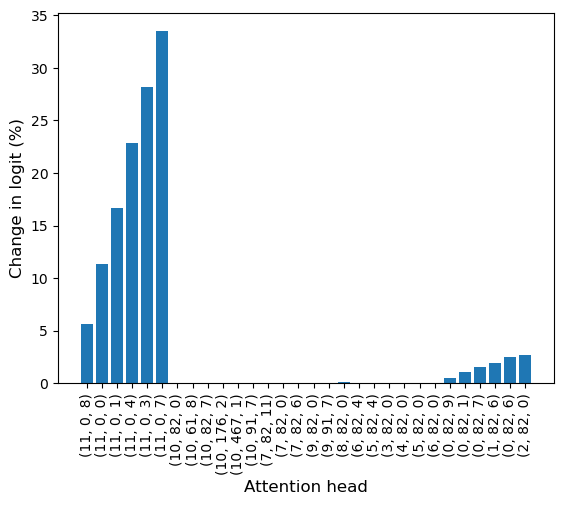

In [97]:
x = range(30)
y = [n/FULL_LOGP*100 for n in min_score_lst]
plt.bar(x, y)
x_labels = [str(v) for v in v_lst]
plt.xticks(x, x_labels, rotation='vertical')
plt.xlabel('Attention head', fontsize=12)
plt.ylabel('Change in logit (%)', fontsize=12)

In [127]:
# NLD_C
with torch.no_grad():
    nld_v_lst = []
    nld_min_score_lst = []
    for i in range(3):
        K = NLD_C[i*6:(i+1)*6]
        score = 0
        for v in K:
            K_minus_v = [h for h in K if h != v]
            for doc, label in tqdm.tqdm(zip(docs, labels)):
                encoding = get_encoding(doc, tokenizer, device)
                label_idx = le_dict[label]
                out1, _ = ablate_target_nodes(encoding, model, [v for v in NLD_C if v not in K])
                out2, _ = ablate_target_nodes(encoding, model, [v for v in NLD_C if v not in K_minus_v])

                score += abs(out1[0][label_idx] - out2[0][label_idx])
            nld_v_lst.append(v)
            nld_min_score_lst.append(score.cpu() / NUM_SAMPLES)   

50it [00:07,  6.26it/s]
50it [00:07,  6.30it/s]
50it [00:07,  6.29it/s]
50it [00:07,  6.28it/s]
50it [00:07,  6.29it/s]
50it [00:07,  6.26it/s]


In [128]:
# NLD_C
with torch.no_grad():
    nld_v_lst = []
    nld_min_score_lst = []
    K = NLD_C[:6]
    for v in NLD_C:
        K_minus_v = [h for h in K if h != v]
        score = 0
        for doc, label in tqdm.tqdm(zip(docs, labels)):
            encoding = get_encoding(doc, tokenizer, device)
            label_idx = le_dict[label]
            out1, _ = ablate_target_nodes(encoding, model, [v for v in NLD_C if v not in K])
            out2, _ = ablate_target_nodes(encoding, model, [v for v in NLD_C if v not in K_minus_v])

            score += abs(out1[0][label_idx] - out2[0][label_idx])
        nld_v_lst.append(v)
        nld_min_score_lst.append(score.cpu() / NUM_SAMPLES)  

50it [00:07,  6.28it/s]
50it [00:07,  6.27it/s]
50it [00:07,  6.28it/s]
50it [00:08,  6.24it/s]
50it [00:08,  6.24it/s]
50it [00:08,  6.21it/s]
50it [00:08,  6.23it/s]
50it [00:08,  6.20it/s]
50it [00:08,  6.18it/s]
50it [00:08,  6.17it/s]
50it [00:08,  6.17it/s]
50it [00:08,  6.19it/s]
50it [00:08,  6.07it/s]
50it [00:08,  6.05it/s]
50it [00:08,  6.10it/s]
50it [00:08,  6.16it/s]
50it [00:08,  6.15it/s]
50it [00:08,  6.13it/s]


Text(0, 0.5, 'Change in logit (%)')

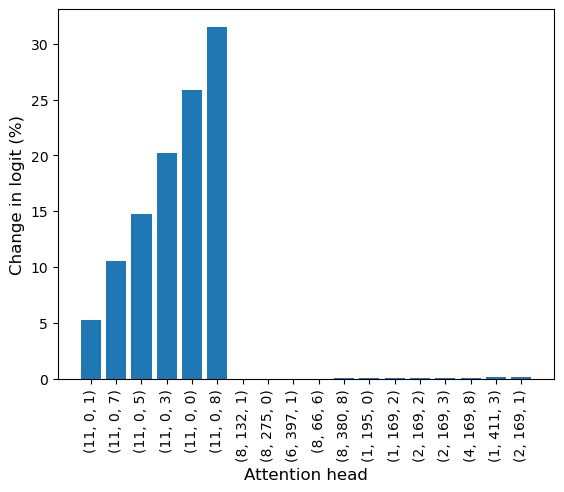

In [99]:
x = range(18)
y = [n/FULL_LOGP*100 for n in nld_min_score_lst]
plt.bar(x, y)
x_labels = [str(v) for v in nld_v_lst]
plt.xticks(x, x_labels, rotation='vertical')
plt.xlabel('Attention head', fontsize=12)
plt.ylabel('Change in logit (%)', fontsize=12)

# Completeness